# TFIDF Text Mining And Clustering
### By taking the tag keywords for each movie, we will find the TFIDF matrices and find the cosine similarity between movies by using the mined text.

#### We will generate the top numbers of similar movies based on the movie input
#### We will to cluster the movies by cosine similarities and Kmeans
#### We will decide on K using the elbow method

In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
from scipy import linalg
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk 

/Users/rosakng/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df = movies_df.drop('genres', 1)
movies_df.head(5)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [3]:
tags_df = pd.read_csv('ml-latest-small/tags.csv')
tags_df = tags_df.drop('timestamp', 1)
tags_df = tags_df.drop('userId', 1)
tags_df.head(5)

,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


In [4]:
# Take only relevant data with movieId, title and tags
movie_tags_df = pd.merge(movies_df, tags_df, on='movieId')
movie_tags_df = movie_tags_df.drop_duplicates()
movie_tags_df.head(5)

,movieId,title,tag
0,1,Toy Story (1995),pixar
2,1,Toy Story (1995),fun
3,2,Jumanji (1995),fantasy
4,2,Jumanji (1995),magic board game
5,2,Jumanji (1995),Robin Williams


In [5]:
# Function for taking movie ID and returning the movie title
def get_movie_title(movie_id):
    df_row = movies_df[movies_df["movieId"] == movie_id]
    movie_row = df_row["title"]
    title = movie_row.values[0]
    return title

In [6]:
# using NLTK from tutorial for cleaning text
# TAKEN FROM TUTORIAL 7
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

import re, string

def clean_text(text):
#     remove text that match reject with numbers and symbols
  text = ''.join([word for word in text if not re.match(r'^-?\d+(?:\.\d+)?$', word)])
  text = ' '.join([word for word in text.split() if word not in stopwords])
  text = ''.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  return text

[nltk_data] Downloading package wordnet to /Users/rosakng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosakng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# This should not return words with numbers
clean_text('1900s stress Hungry')

'stress hungry'

In [8]:
# This may take a minute to load
# Group by movieId to consolidate all tags for a movie in a row
movie_tags_df = movie_tags_df.groupby(['movieId']).tag.apply(list).reset_index()
movie_tags_df['tag'] = movie_tags_df['tag'].str.join(' ')
movie_tags_df['title'] = movie_tags_df.apply(lambda row: get_movie_title(row.movieId), axis=1)
movie_tags_df.head()

,movieId,tag,title
0,1,pixar fun,Toy Story (1995)
1,2,fantasy magic board game Robin Williams game,Jumanji (1995)
2,3,moldy old,Grumpier Old Men (1995)
3,5,pregnancy remake,Father of the Bride Part II (1995)
4,7,remake,Sabrina (1995)


In [9]:
# Use tutorial's lemmatizing function to clean text
# TAKEN FROM TUTORIAL 7
wn = nltk.WordNetLemmatizer()
def lemmatizing(text):
  text = [wn.lemmatize(word) for word in text.split()]
  return str(text)
tag_text_df = movie_tags_df.copy()
tag_text_df = tag_text_df.drop('title', 1)
tag_text_df['tag1'] = tag_text_df['tag'].apply(lambda x: clean_text(str(x.strip())))
tag_text_df['tag2'] = tag_text_df['tag1'].apply(lambda x: lemmatizing(x))
tag_text_df.head()

,movieId,tag,tag1,tag2
0,1,pixar fun,pixar fun,"['pixar', 'fun']"
1,2,fantasy magic board game Robin Williams game,fantasy magic board game robin williams game,"['fantasy', 'magic', 'board', 'game', 'robin',..."
2,3,moldy old,moldy old,"['moldy', 'old']"
3,5,pregnancy remake,pregnancy remake,"['pregnancy', 'remake']"
4,7,remake,remake,['remake']


In [10]:
# Apply vectorizer to tag text 
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(tag_text_df['tag2'])

In [11]:
# TAKEN FROM TUTORIAL 7
# Apply topic modelling to generate term frequencies for 10 groups
import collections
clf = decomposition.NMF(n_components=10,random_state=1)
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_
vocab = np.array(vectorizer_tfidf.get_feature_names())
topics_frequency = collections.Counter(np.array(W1.argsort()[:,-1]))
topics_frequency = collections.OrderedDict(sorted(topics_frequency.items(),key= lambda kv: kv[1],reverse=True))
total_comments_count = sum(topics_frequency.values())

print('Top', 10, 'topics:')
for k,v in topics_frequency.items():
  print('Topic {}: {}'.format(k+1, ", ".join([str(x) for x in vocab[(-H1[k]).argsort(axis=-1)[:10]]])))

Top 10 topics:
Topic 10: king, stephen, superhero, comedy, arthur, alien, england, dark, atmospheric, ending
Topic 1: queue, netflix, available, boxing, vietnam, holocaust, police, judaism, biopic, aid
Topic 8: politics, president, terrorism, africa, racism, cia, thrilling, business, south, america
Topic 3: movie, business, animal, music, hollywood, eerie, animation, lion, bear, camel
Topic 7: war, world, ii, civil, cold, holocaust, journalism, gulf, anime, europe
Topic 9: christmas, york, new, halloween, homeless, bad, city, frontal, nudity, controversial
Topic 4: religion, bible, pregnancy, classic, court, priest, saint, preacher, convent, business
Topic 2: disney, race, nanny, fish, animation, arthur, heartwarming, original, music, samuel
Topic 5: school, high, funny, teacher, highschool, prom, subtext, lesbian, clever, fantasy
Topic 6: shakespeare, sort, space, cinematography, classic, updated, amazing, leonardo, dicaprio, nasa


/Users/rosakng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


# Calculating Similarity

In [12]:
# Use cosine similarity function with the document term vectors to generate similarity scores
cos_similarity = cosine_similarity(vectors_tfidf)

In [13]:
# Creates a frame with movieIds and new indexes starting from 0 (Used for finding groups of similarity with a movieId)
movie_index_df = pd.Series(movie_tags_df.index, index=movie_tags_df['movieId']).drop_duplicates()
movie_index_df.head(20)

movieId
1      0
2      1
3      2
5      3
7      4
11     5
14     6
16     7
17     8
21     9
22    10
25    11
26    12
28    13
29    14
31    15
32    16
34    17
36    18
38    19
dtype: int64

In [14]:
def get_similar_movies(movieId, num_results, cos_similarity=cos_similarity):
    # Movie index of movieId from all_movie_indices
    movie_index = movie_index_df[movieId]
    # Similarity scores of movies corresponding to movieId
    similarity_scores = list(enumerate(cos_similarity[movie_index]))
    # Sort movies based on the similarity scores in descending order
    sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_results+1]
    # Get the top movie data corresponding to subset of scores
    similar_indexes = [i[0] for i in sorted_similarity_scores]
    # Return most similar movies
    return movie_tags_df['title'].iloc[similar_indexes]

In [15]:
get_similar_movies(1, 20)

544                   Bug's Life, A (1998)
1524      Guardians of the Galaxy 2 (2017)
666                     Toy Story 2 (1999)
1510                     Big Hero 6 (2014)
1497                 The Lego Movie (2014)
1457                  Avengers, The (2012)
1427                             Up (2009)
77                     Pulp Fiction (1994)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3       Father of the Bride Part II (1995)
4                           Sabrina (1995)
5           American President, The (1995)
6                             Nixon (1995)
7                            Casino (1995)
8             Sense and Sensibility (1995)
9                        Get Shorty (1995)
10                          Copycat (1995)
11                Leaving Las Vegas (1995)
12                          Othello (1995)
Name: title, dtype: object

In [16]:
print(cos_similarity)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


# Clustering

In [17]:
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
%matplotlib inline

In [19]:
# Apply KMeans with the tfidf vectors to create K=8 clusters
clustering  = KMeans(n_clusters=8)
clustering.fit(vectors_tfidf)
clusters = clustering.labels_.tolist()

In [20]:
titles = movie_tags_df.title.to_numpy()
# Create a new dataframe of cluster values and corresponding titles
cluster_frame = pd.DataFrame({'title': titles, 'cluster': clusters}, index=[clusters], columns = ['title', 'cluster'])
cluster_frame.head()

,title,cluster
0,Toy Story (1995),0
0,Jumanji (1995),0
0,Grumpier Old Men (1995),0
0,Father of the Bride Part II (1995),0
0,Sabrina (1995),0


In [21]:
# Number of movies per cluster
print(cluster_frame['cluster'].value_counts())

0    1223
4     120
3      84
5      67
7      21
6      20
2      19
1      18
Name: cluster, dtype: int64


In [22]:
# This cell may take a minute to load
import matplotlib as mpl

from sklearn.manifold import MDS

# "MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces."
# - MDS is a common way to visualize common groups of text using TFIDF vectorization
# https://scikit-learn.org/stable/modules/manifold.html

# Set dissimilarity as "precomputed" because we are inputting a pre-computed distance matrix
# Set components = 2 for 2D space
mds = MDS(n_components=2, dissimilarity="precomputed")

# The cosine distances of each plot is 1-cosine similarity between the plots
# Since we want to see the distances representative of each plot rather than similarity relative to each other, we plot using the cosine distances
cosine_distances = 1-cos_similarity
X_2D_values = mds.fit_transform(cosine_distances)
# Setting all target values for X as 0 and y as 1 (See cosine similarity data which contain 0's and 1's)
x, y = X_2D_values[:, 0], X_2D_values[:, 1]

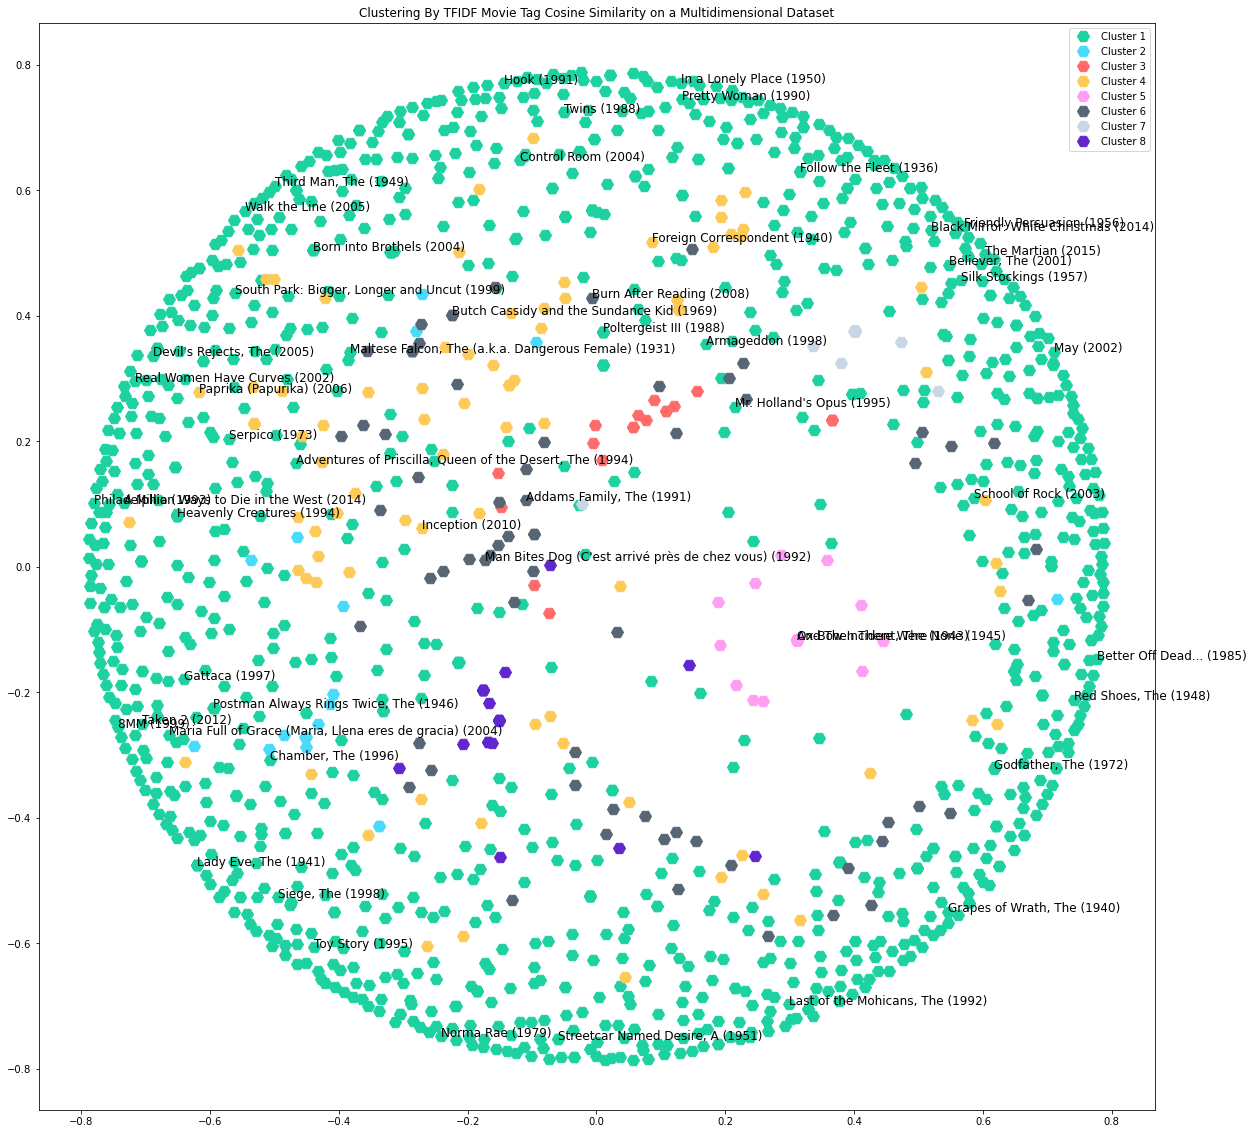

In [23]:
cluster_colors = {0: '#1dd1a1', 1: '#48dbfb', 2: '#ff6b6b', 3: '#feca57', 4: '#ff9ff3', 5: '#576574', 6: '#c8d6e5', 7: '#5f27cd'}
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6', 6: 'Cluster 7', 7: 'Cluster 8'}

graph_df = pd.DataFrame(dict(x_axis=x, y_axis=y, label=clusters, movie_title=titles)) 

#Create groups for each cluster
groups = graph_df.groupby('label')

# Create a figure an plot for both axes and set sizing
figure, axes = plt.subplots(figsize=(20, 20))

for name, group in groups:
    axes.plot(
        group.x_axis, group.y_axis, marker='H', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name]
    )

axes.set_title('Clustering By TFIDF Movie Tag Cosine Similarity on a Multidimensional Dataset')

# Legend
axes.legend()

#Dispersed Film title labels for every 50 movies
i = 0
while i <= 1572:
    axes.text(graph_df.iloc[i]['x_axis'], graph_df.iloc[i]['y_axis'], graph_df.iloc[i]['movie_title'], size=12)
    i += 30

plt.show()

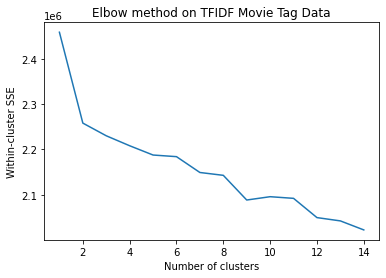

In [24]:
# TAKEN FROM TUTORIAL
# Use elbow method to find the fitting number of clusters
from sklearn.preprocessing import scale

X = scale(cos_similarity)

#Elbow method
distortations = {}
for k in range(1,15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()),list(distortations.values()))
plt.title('Elbow method on TFIDF Movie Tag Data')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

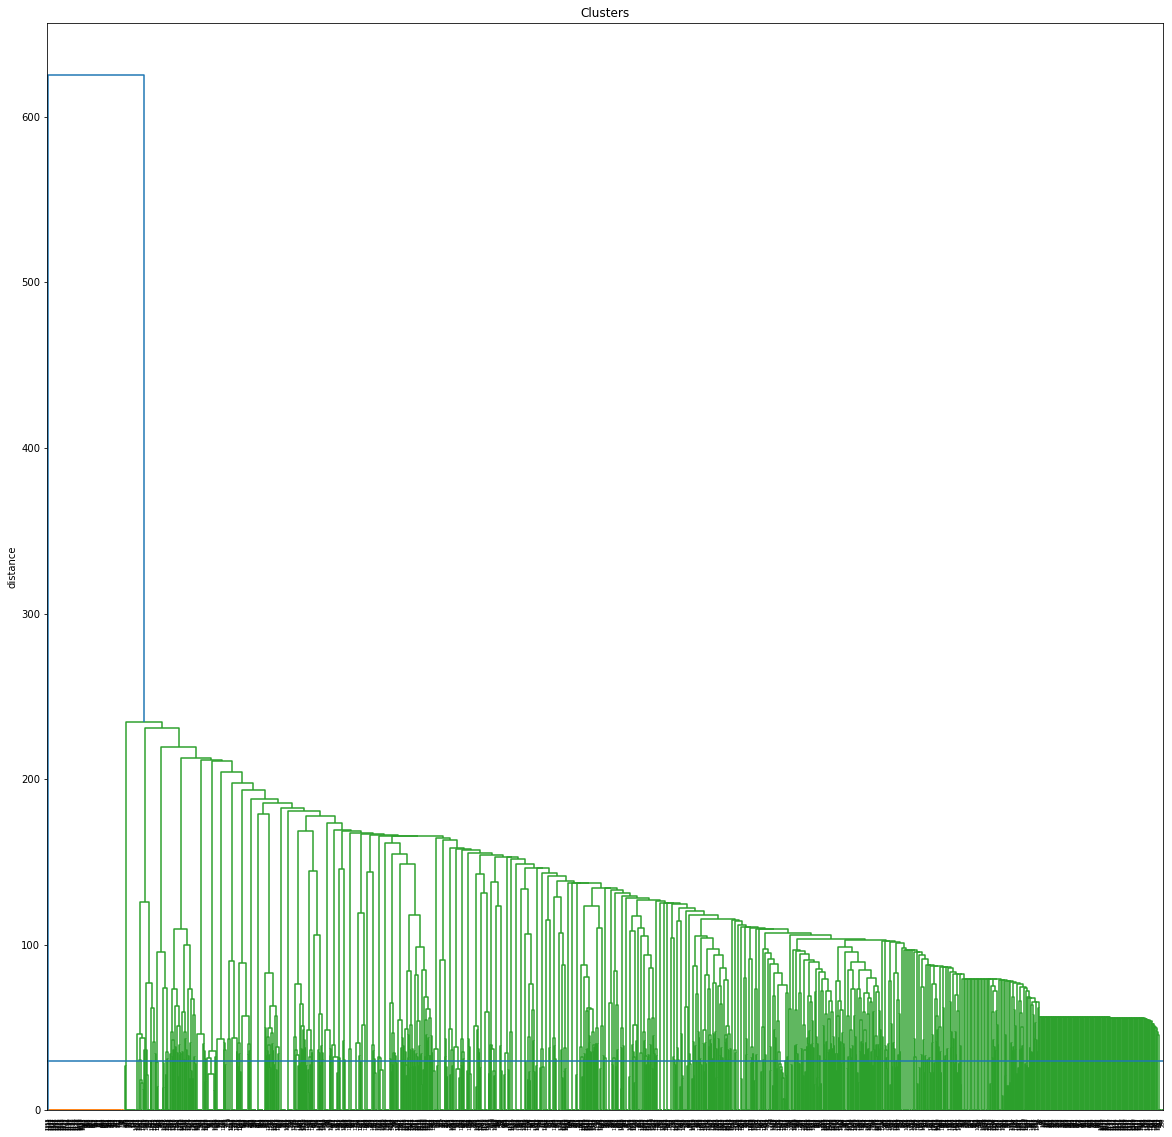

In [25]:
# TAKEN FROM TUTORIAL: show dendrogram of results
from scipy.cluster.hierarchy import dendrogram, linkage

# This dendrogram is shown for the purpose of seeing the dispersion of clusters
Z = linkage(scale(cosine_distances),'ward')

plt.figure(figsize=(20,20))
plt.title('Clusters')
plt.ylabel('distance')
# Removing labels along the x-axis due to all movies overlapping
plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')

dendrogram(Z)

plt.axhline(y=30)
plt.show()